2024-12-24 07:51:43,111 - INFO - Initializing the Hybrid Quantum-Classical Neural Network
2024-12-24 07:51:43,111 - INFO - Initializing Data Loaders
2024-12-24 07:51:43,111 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-24 07:51:43,138 - INFO - Loaded 2880 samples.
2024-12-24 07:51:43,139 - INFO - Data Loaders initialized successfully: 2304 training samples, 576 testing samples
2024-12-24 07:51:43,142 - INFO - Model architecture:
HybridModel(
  (fc1): Linear(in_features=784, out_features=4, bias=True)
  (quantum): QuantumLayer()
  (fc2): Linear(in_features=4, out_features=10, bias=True)
)
2024-12-24 07:51:43,143 - INFO - Starting training process
2024-12-24 07:51:43,143 - INFO - Starting training for 20 epochs
2024-12-24 07:51:47,258 - INFO - Epoch 1/20 - Average Loss: 2.4160    
2024-12-24 07:51:50,754 - INFO - Epoch 2/20 - Average Loss: 2.3554    
2024-12-24 07:51:54,216 - INFO - Epoch 3/20 - Average Loss: 2.3266    

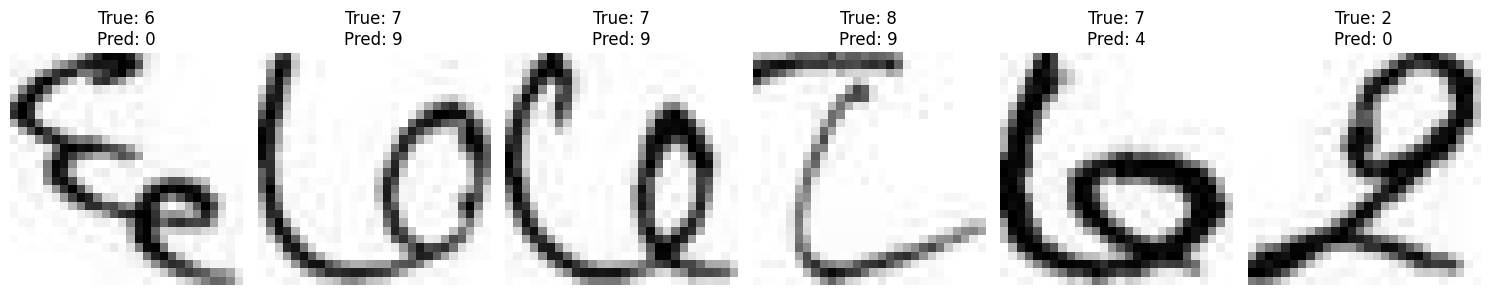

2024-12-24 07:53:05,833 - INFO - Visualization complete
2024-12-24 07:53:05,835 - INFO - Hybrid Quantum-Classical Neural Network execution completed


In [1]:
# hybrid_quantum_classical_nn.py

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm  # For progress bars
import pennylane as qml
from pennylane import numpy as pnp

# Setting up logging
def setup_logging(log_file='training.log'):
    """
    Sets up logging to output to both console and a file with a specific format.
    Args:
        log_file (str): Filename for the log file.
    """
    logger = logging.getLogger('HybridQuantumClassicalNN')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add it to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to the logger
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# Define Dataset Class
class NepaliMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in subdirectories per class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info("Loading dataset from directory: %s", root_dir)
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning("Directory for label %d does not exist: %s", label, label_dir)
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info("Loaded %d samples.", len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Paths
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=32):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    logger.info("Data Loaders initialized successfully: %d training samples, %d testing samples", train_size, test_size)
    return train_loader, test_loader

# Quantum Layer using PennyLane
n_qubits = 4  # Increased number of qubits for better representation
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(weights, inputs):
    """
    Defines a quantum circuit with parameterized gates.
    Args:
        weights (Tensor): Trainable weights for the circuit.
        inputs (Tensor): Input data encoded into the circuit.
    Returns:
        List[Expectation values]: Expectation values for each qubit.
    """
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Entangling layer
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    
    # Parameterized rotations
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QNode
@qml.qnode(dev, interface='torch', diff_method='parameter-shift')
def qnode(weights, inputs):
    return quantum_circuit(weights, inputs)

class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Initialize weights for the quantum circuit
        self.weights = nn.Parameter(0.01 * torch.randn(n_qubits))
    
    def forward(self, x):
        # Ensure the input is the same size as the number of qubits
        if x.size(1) != n_qubits:
            raise ValueError(f"Expected input size {n_qubits}, got {x.size(1)}")
        
        # Process each sample in the batch individually
        outputs = [qnode(self.weights, sample) for sample in x]
        
        # Convert each output to a tensor if it's a list or scalar
        processed_outputs = []
        for o in outputs:
            if isinstance(o, list):
                o = torch.tensor(o, dtype=torch.float32)
            elif isinstance(o, (float, int)):
                o = torch.tensor([o], dtype=torch.float32)
            elif isinstance(o, torch.Tensor):
                o = o.float()
            else:
                raise TypeError(f"Unsupported output type: {type(o)}")
            processed_outputs.append(o)
        
        # Stack the outputs into a tensor
        return torch.stack(processed_outputs)

# Building the Hybrid Neural Network
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, n_qubits)  # Map to number of qubits
        self.quantum = QuantumLayer()
        self.fc2 = nn.Linear(n_qubits, 10)       # Output for 10 classes

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.quantum(x)
        x = self.fc2(x)
        return x

# Training and Evaluation Functions
def train_model(model, train_loader, optimizer, loss_fn, epochs):
    """
    Trains the model for a specified number of epochs.
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        loss_fn (nn.Module): Loss function.
        epochs (int): Number of training epochs.
    """
    logger.info("Starting training for %d epochs", epochs)
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', leave=False)
        for images, labels in progress_bar:
            images = images.view(-1, 28*28)  # Flatten the image
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})
        avg_loss = epoch_loss / len(train_loader)
        logger.info(f"Epoch {epoch}/{epochs} - Average Loss: {avg_loss:.4f}")

def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test dataset and returns the accuracy.
    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for testing data.
    Returns:
        float: Accuracy percentage.
    """
    logger.info("Starting evaluation")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images = images.view(-1, 28*28)  # Flatten the image
            labels = labels.long()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    logger.info(f"Evaluation completed with Accuracy: {accuracy:.2f}%")
    return accuracy

def visualize_predictions(model, test_loader, num_images=6):
    """
    Visualizes a few predictions from the model.
    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for testing data.
        num_images (int): Number of images to visualize.
    """
    logger.info("Visualizing predictions")
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.view(-1, 28*28)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        if idx >= len(images):
            break
        image = images[idx].numpy().reshape(28, 28)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"True: {labels[idx].item()}\nPred: {predictions[idx].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    logger.info("Visualization complete")

# Main execution
def main():
    logger.info("Initializing the Hybrid Quantum-Classical Neural Network")
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR)

    model = HybridModel()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    logger.info("Model architecture:\n%s", model)
    logger.info("Starting training process")
    train_model(model, train_loader, optimizer, loss_fn, epochs=20)  # Increased epochs

    logger.info("Starting evaluation on test data")
    accuracy = evaluate_model(model, test_loader)
    logger.info(f"Test Accuracy: {accuracy:.2f}%")

    logger.info("Starting visualization of predictions")
    visualize_predictions(model, test_loader)

    logger.info("Hybrid Quantum-Classical Neural Network execution completed")

if __name__ == "__main__":
    main()
